In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sc
import scipy

In [39]:
matplotlib.rcParams['axes.titlesize'] = '20'
matplotlib.rcParams['legend.fontsize'] = '14'
matplotlib.rcParams['axes.labelsize'] = '14'

In [40]:
# Read Mono Calibration parameters
calibration_CCD = pd.read_csv('CCD_params.csv')
calibration_Mono = pd.read_csv('Mono_params.csv')

c_a = calibration_Mono['params_linear'][0]
c_b = calibration_Mono['params_linear'][1]
u_c_a = calibration_Mono['cov_linear'][0]
u_c_b = calibration_Mono['cov_linear'][1]


def wave(lamb, u_lamb):
    w = lamb * c_a + c_b
    u_w = np.sqrt((lamb * u_c_a)**2 + (u_c_b)**2 + (c_a * u_lamb)**2)
    return w, u_w


w_laser = calibration_CCD['laser_corr']


def d_v(lamb, u_lamb):
    v = 1/w_laser[0] - 1/lamb
    u_v = np.sqrt((w_laser[1]/w_laser[0]**2)**2 + (u_lamb/lamb**2)**2)
    return v, u_v

In [41]:
def lorentz(x, A, w0, gamma, C):
    '''Function of a Lorentz-curve.

    w0 : position of maximum
    gamma : curve width
    '''
    return A/((x**2 - w0**2)**2 + gamma**2 * w0**2) + C


def voigt(x, mean, sigma, gamma, A, c):
    return A * scipy.special.voigt_profile(x-mean, sigma, gamma) + c

def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2)) + C

def doppel_gauss(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    return (A1 * np.exp(-(x-mu1)**2 / (2*sigma1**2)) + A2 * np.exp(-(x-mu2)**2 / (2*sigma2**2))) + C

In [42]:
def save_params(spectrum, coefficients, covariance):
    wavelength = []
    u_wavelength = []
    dvs = []
    u_dvs = []
    for i in range(len(coefficients)):
        if coefficients[i,1] > 0:
            w = wave(coefficients[i,1], np.sqrt(covariance[i,1,1]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
        
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))
        if coefficients[i,4] > 0:
            w = wave(coefficients[i,4], np.sqrt(covariance[i,4,4]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))

    output_data = pd.DataFrame({#'$\\lambda\ind{Mono}$ [$\\mathrm{\\AA}$]': wavelength,
                                #'$u(\\lambda\ind{Mono})$ [$\\mathrm{\\AA}$]': u_wavelength,
                                '$d_\\nu$ [$\mathrm{cm}^{-1}$]': dvs,
                                '$u(d_\\nu)$ [$\mathrm{cm}^{-1}$]': u_dvs})

    output_data.to_csv('Calibration_Files_Mono/Mono_'+ spectrum + '.csv', index=False, sep=',')
    print('Successfully saved!')

In [43]:
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

def draw_spectrum(num_fit, x, y, a, xaxis,xaxis1, coefficients,
                  covariance, title, spectrum, func1=gauss,func2=gauss,
                  log=False, ylims=[0,500],
                  xlims=[5050,5600], avline=True,
                  loc='lower right'):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(x, y, marker = 'x', lw = 0, ms = 5, color = 'grey')
    
    i=0
    j=2
    if func1==doppel_gauss:
        params = coefficients[i]
        cov = covariance[i]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_1 = ({:.1f} \pm {:.1f})\,\AA$, $\mu_2 = ({:.1f} \pm {:.1f})$'.format(
            params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4]))+r'$\,\mathrm{\AA}$')

    elif func1==gauss:
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_1 = ({:.1f} \pm {:.1f})$'.format(
            params[1], np.sqrt(cov[1,1]))+r'$\,\mathrm{\AA}$')

    for i in range(1,num_fit-1):
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        j+=1
        ax.plot(xaxis[i],gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{} = ({:.2f} \pm {:.2f})$'.format(j, params[1], np.sqrt(cov[1,1]))+r'$\,\mathrm{\AA}$')
            
    i=i+1
    if func2==doppel_gauss:
        params = coefficients[i]
        cov = covariance[i]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_{} = ({:.1f} \pm {:.1f})\,\AA$, $\mu_{} = ({:.1f} \pm {:.1f})$'.format(j+1,
            params[1], np.sqrt(cov[1,1]),j+2, params[4], np.sqrt(cov[4,4]))+r'$\,\mathrm{\AA}$')
    else:
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_{} = ({:.1f} \pm {:.1f})$'.format(j+1,
            params[1], np.sqrt(cov[1,1]))+r'$\,\mathrm{\AA}$')
    
    ax.set_xlabel(r'Channel $x_\mathrm{Mono}\,[\mathrm{\AA}]$')
    ax.set_ylabel(r'Intensity [a.u.]')
    ax.set_title(title)
    ax.axvline(5318.180, ls='--', color = 'green', label=r'laser wavelength', lw=1)
    ax.legend(loc=loc)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if log:
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig('MonoFigures/'+spectrum+'_spectrum.pdf', dpi=800)
    plt.show()

In [44]:
def fit_func(N, x, y, a, p0s,p1s, func1, func2, show):
    coefficients = np.zeros((N, 7))
    covariance = np.zeros((N, 7, 7))
    i = 0
    if func1==gauss:
        params, cov = sc.curve_fit(func1, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p0s[i])
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    elif func1==doppel_gauss:
        params, cov = sc.curve_fit(func1, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p1s[0])
        coefficients[i] = params
        covariance[i] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))

    for i in range(1,N-1):
        params, cov = sc.curve_fit(gauss, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]], p0 = p0s[i])
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
    i = i+1
    if func2==gauss:
        params, cov = sc.curve_fit(func2, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p0s[i])
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    elif func2==doppel_gauss:
        params, cov = sc.curve_fit(func2, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p1s[1])
        coefficients[i] = params
        covariance[i] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    return coefficients, covariance

In [45]:
file_1 = 'Mono/white_light_0degree.dig'
file_2 = 'Mono/white_light_90degree.dig'
df0 = pd.read_csv(file_1, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')
df90 = pd.read_csv(file_2, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

[-3.40076010e-04  2.78766645e+00] [2.48980873e-06 1.37115540e-02] [-0.00732133  0.00491865]


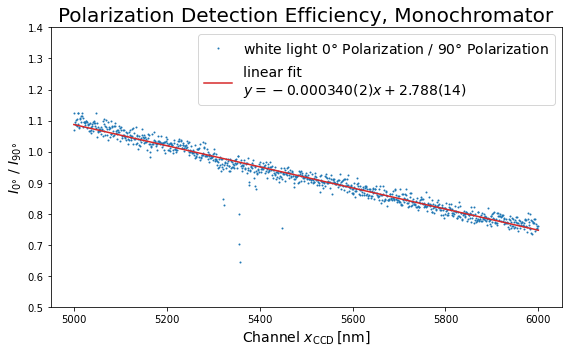

In [46]:
x0, y0 = df0['Channel'][1099:2099], df0['Counts'][1099:2099]
x90, y90 = df90['Channel'][1099:2099], df90['Counts'][1099:2099]

lin_par, lin_cov = np.polyfit(x0, y0/y90, 1, rcond=None, full=False, w=None, cov=True)

print(lin_par, np.sqrt(np.diagonal(lin_cov)), np.sqrt(np.diagonal(lin_cov)) / lin_par)

xaxis = np.linspace(5000, 6000, 1001)

fig, ax = plt.subplots(figsize = (8,5))
# ax.plot(x0, y0, marker = 'x', lw=0.5, ms = 2, label = r'white light $0\degree$ Polarization filter', color = 'C0')
# ax.plot(x0, y0, marker = 'x', lw=0.5, ms = 2, label= r'white light $90\degree$ Polarization filter', color = 'C1')
ax.plot(x0, y0/y90, marker = '.', lw=0, ms = 2,
        label= r'white light $0\degree$ Polarization / $90\degree$ Polarization', color = 'C0')
ax.plot(xaxis, np.polyval(lin_par, xaxis), color = 'C3', label ='linear fit \n' + r'$y={:.6f}(2) x + {:.3f}(14)$'.format(*lin_par))
ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'$I_{0\degree}~/~I_{90\degree}$')
ax.set_title(r'Polarization Detection Efficiency, Monochromator')
ax.set_ylim(0, 3)
# ax.set_xlim(5000, 6000)
ax.set_ylim(0.5, 1.4)
ax.legend()
plt.tight_layout()
# plt.savefig('Figures/Notchfilter.pdf', dpi=800)
plt.show()

**CCl4 Spectrum**

In [47]:
file_CCl4 = 'Mono/CCl4_spectrum_2.dig'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

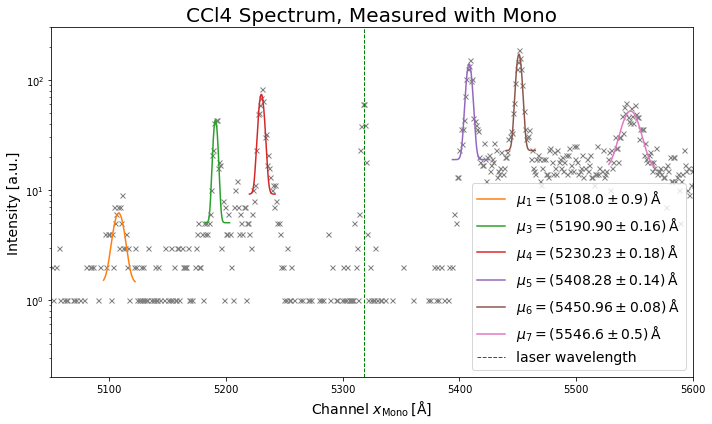

In [48]:
title = r'CCl4 Spectrum, Measured with Mono'
spectrum = 'CCl4'
N = 6
p1s=[]
func1=gauss
func2=gauss
y_counts = df_CCl4['Counts']
a = [[196, 216], [280, 300], [320, 340], [495, 525], [535, 565], [630, 670]]
p0s = [[7, 5110, 10, 0], [40, 5190, 10, 0], [70, 5230, 10, 0],
       [150, 5410, 10, 0], [175, 5450, 10, 0], [100, 5545, 10, 0]]
xaxis = [np.linspace(5095, 5122, 1001), np.linspace(5182, 5203, 1001), np.linspace(5220, 5242, 1001),
         np.linspace(5394, 5425, 1001), np.linspace(5440,5465,1001), np.linspace(5528, 5568, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df_CCl4['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
draw_spectrum(num_fit=N, x=df_CCl4['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[0.2,300], xlims=[5050,5600],avline=0, loc='lower right')

In [49]:
save_params(spectrum, coefficients, covariance)

lambda = 511.17 \pm 0.1
d_nu = -770 \pm 7.2
lambda = 519.46 \pm 0.053
d_nu = -458 \pm 6.4
lambda = 523.39 \pm 0.054
d_nu = -313 \pm 6.4
lambda = 541.19 \pm 0.054
d_nu = 315 \pm 6.3
lambda = 545.45 \pm 0.053
d_nu = 460 \pm 6.3
lambda = 555.01 \pm 0.074
d_nu = 775 \pm 6.5
Successfully saved!


**CCl4 with lamb**

In [50]:
file_CCl4 = 'Mono/CCl4_spectrum_lamb_2.dig'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

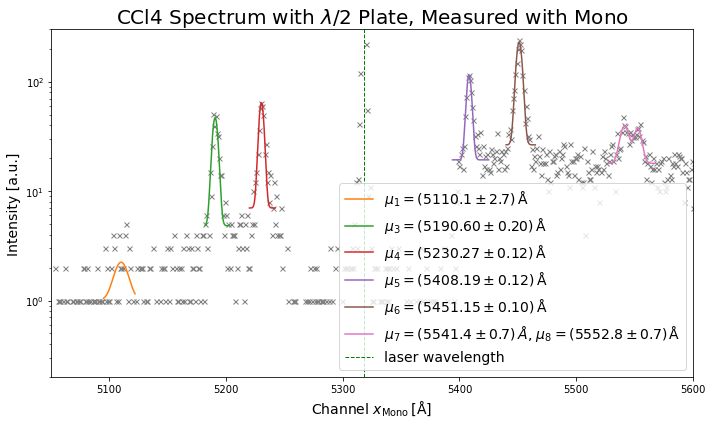

In [51]:
title = r'CCl4 Spectrum with $\lambda/2$ Plate, Measured with Mono'
spectrum = 'CCl4_lamb'
N = 6
func1=gauss
func2=doppel_gauss
y_counts = df_CCl4['Counts']
a = [[187, 226], [280, 300], [318, 340], [495, 525], [535, 565], [633, 662]]
p1s = [[7, 5105, 10, 7, 5110,10, 0], [50, 5540, 10, 50, 5551, 10, 0]]
p0s = [[7, 5105, 10, 0], [40, 5190, 10, 0], [70, 5230, 10, 0],
       [150, 5410, 10, 0], [175, 5450, 10, 0], [100, 5545, 10, 0]]
xaxis = [np.linspace(5095, 5122, 1001), np.linspace(5182, 5203, 1001), np.linspace(5220, 5242, 1001),
         np.linspace(5394, 5425, 1001), np.linspace(5440,5465,1001), np.linspace(5528, 5568, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df_CCl4['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
draw_spectrum(num_fit=N, x=df_CCl4['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[0.2,300], xlims=[5050,5600],avline=0, loc='lower right')

In [52]:
save_params(spectrum, coefficients, covariance)

lambda = 511.38 \pm 0.27
d_nu = -762 \pm 12
lambda = 519.43 \pm 0.054
d_nu = -459 \pm 6.4
lambda = 523.4 \pm 0.052
d_nu = -313 \pm 6.3
lambda = 541.18 \pm 0.053
d_nu = 315 \pm 6.3
lambda = 545.47 \pm 0.053
d_nu = 460 \pm 6.3
lambda = 554.49 \pm 0.085
d_nu = 758 \pm 6.6
lambda = 555.63 \pm 0.088
d_nu = 795 \pm 6.7
Successfully saved!


**CCl4 0 degree**

In [53]:
file_CCl4 = 'Mono/CCl4_spectrum_0deg_2.dig'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

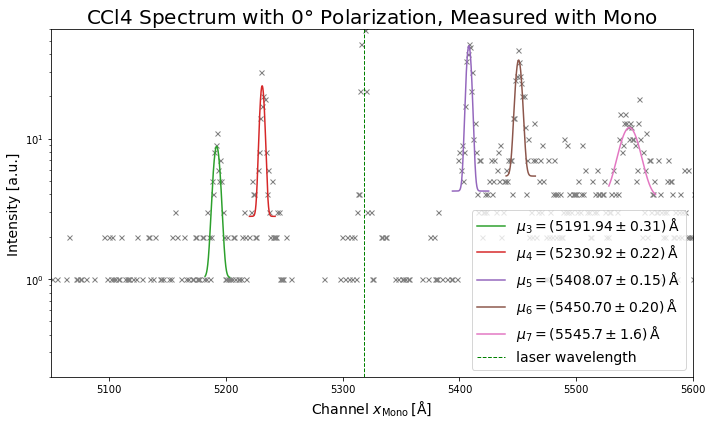

In [54]:
I_0 = np.zeros((5, 4))
title = r'CCl4 Spectrum with $0\degree$ Polarization, Measured with Mono'
spectrum = 'CCl4_0deg'
N = 6
func1=0
func2=gauss
y_counts = df_CCl4['Counts']
a = [[187, 226], [280, 300], [318, 340], [495, 525], [535, 565], [633, 662]]
p1s = [[7, 5105, 10, 7, 5110,10, 0], [10, 5541, 10, 10, 5552, 10, 0]]
p0s = [[7, 5105, 10, 0], [40, 5190, 10, 0], [70, 5230, 10, 0],
       [150, 5410, 10, 0], [175, 5450, 10, 0], [10, 5545, 10, 0]]
xaxis = [np.linspace(5095, 5122, 1001), np.linspace(5182, 5203, 1001), np.linspace(5220, 5242, 1001),
         np.linspace(5394, 5425, 1001), np.linspace(5440,5465,1001), np.linspace(5528, 5568, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df_CCl4['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
# print("Coefficients = ", coefficients[1:,:4])
# print('covariance =', covariance[1:,:4,:4])
I_0[:,0], I_0[:,2] = coefficients[1:,0], coefficients[1:,1]
I_0[:,1], I_0[:,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
draw_spectrum(num_fit=N, x=df_CCl4['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[0.2,60], xlims=[5050,5600],avline=0, loc='lower right')

In [55]:
save_params(spectrum, coefficients, covariance)

lambda = 519.57 \pm 0.059
d_nu = -454 \pm 6.4
lambda = 523.46 \pm 0.055
d_nu = -311 \pm 6.4
lambda = 541.17 \pm 0.054
d_nu = 314 \pm 6.3
lambda = 545.43 \pm 0.056
d_nu = 459 \pm 6.3
lambda = 554.92 \pm 0.17
d_nu = 772 \pm 8.1
Successfully saved!


**CCl4 lamb 0 deg**

In [56]:
file_CCl4 = 'Mono/CCl4_spectrum_lamb_0deg_2.dig'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

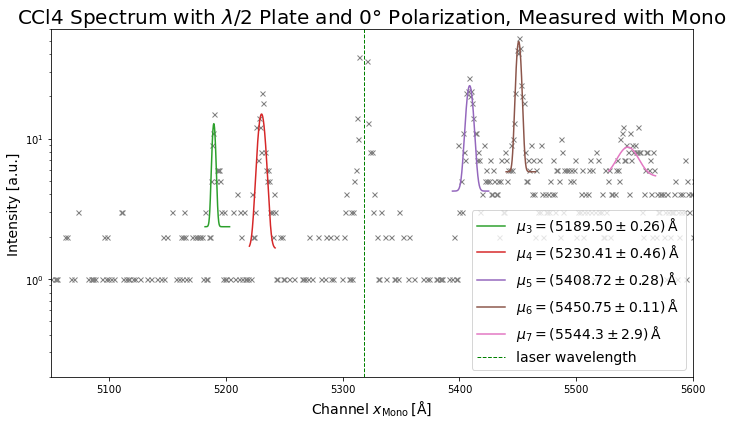

In [57]:
I_lamb0 = np.zeros((5,4))
title = r'CCl4 Spectrum with $\lambda/2$ Plate and $0\degree$ Polarization, Measured with Mono'
spectrum = 'CCl4_lamb_0deg'
N = 6
func1=0
func2=gauss
y_counts = df_CCl4['Counts']
a = [[185, 230], [280, 300], [318, 340], [495, 525], [535, 565], [634, 662]]
p1s = [[7, 5105, 10, 7, 5110,10, 0], [10, 5541, 10, 10, 5552, 10, 0]]
p0s = [[7, 5105, 10, 0], [10, 5190, 10, 0], [10, 5230, 10, 0],
       [20, 5410, 10, 0], [30, 5450, 10, 0], [10, 5545, 10, 5]]
xaxis = [np.linspace(5095, 5122, 1001), np.linspace(5182, 5203, 1001), np.linspace(5220, 5242, 1001),
         np.linspace(5394, 5425, 1001), np.linspace(5440,5465,1001), np.linspace(5528, 5568, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df_CCl4['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
I_lamb0[:,0], I_lamb0[:,2] = coefficients[1:,0], coefficients[1:,1]
I_lamb0[:,1], I_lamb0[:,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
draw_spectrum(num_fit=N, x=df_CCl4['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[0.2,60], xlims=[5050,5600],avline=0, loc='lower right')

In [58]:
save_params(spectrum, coefficients, covariance)

lambda = 519.32 \pm 0.057
d_nu = -463 \pm 6.4
lambda = 523.41 \pm 0.069
d_nu = -313 \pm 6.5
lambda = 541.23 \pm 0.059
d_nu = 317 \pm 6.4
lambda = 545.43 \pm 0.053
d_nu = 459 \pm 6.3
lambda = 554.78 \pm 0.29
d_nu = 768 \pm 11
Successfully saved!


**CCl4 90 deg**

In [59]:
file_CCl4 = 'Mono/CCl4_spectrum_90deg_2.dig'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

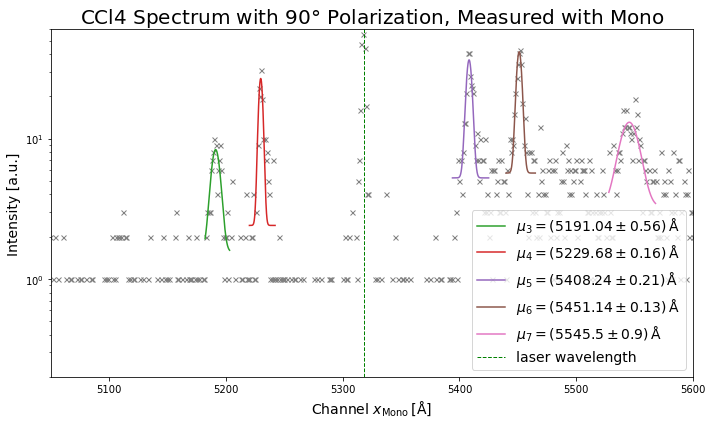

In [60]:
I_90 = np.zeros((5,4))
title = r'CCl4 Spectrum with $90\degree$ Polarization, Measured with Mono'
spectrum = 'CCl4_90deg'
N = 6
func1=0
func2=gauss
y_counts = df_CCl4['Counts']
a = [[187, 226], [281, 305], [315, 345], [495, 525], [535, 565], [634, 670]]
p1s = [[7, 5105, 10, 7, 5110,10, 0], [10, 5541, 10, 10, 5552, 10, 0]]
p0s = [[7, 5105, 10, 0], [40, 5190, 10, 0], [70, 5230, 10, 0],
       [150, 5410, 10, 0], [175, 5450, 10, 0], [10, 5545, 10, 5]]
xaxis = [np.linspace(5095, 5122, 1001), np.linspace(5182, 5203, 1001), np.linspace(5220, 5242, 1001),
         np.linspace(5394, 5425, 1001), np.linspace(5440,5465,1001), np.linspace(5528, 5568, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df_CCl4['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
I_90[:,0], I_90[:,2] = coefficients[1:,0], coefficients[1:,1]
I_90[:,1], I_90[:,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
draw_spectrum(num_fit=N, x=df_CCl4['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2, spectrum=spectrum, log=True, ylims=[0.2,60], xlims=[5050,5600], avline=0, loc='lower right')

In [61]:
save_params(spectrum, coefficients, covariance)

lambda = 519.48 \pm 0.075
d_nu = -457 \pm 6.7
lambda = 523.34 \pm 0.053
d_nu = -315 \pm 6.3
lambda = 541.18 \pm 0.056
d_nu = 315 \pm 6.3
lambda = 545.47 \pm 0.053
d_nu = 460 \pm 6.3
lambda = 554.9 \pm 0.11
d_nu = 772 \pm 7
Successfully saved!


**CCl4 lamb 90 deg**

In [62]:
file_CCl4 = 'Mono/CCl4_spectrum_lamb_90deg_2.dig'
df_CCl4 = pd.read_csv(file_CCl4, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

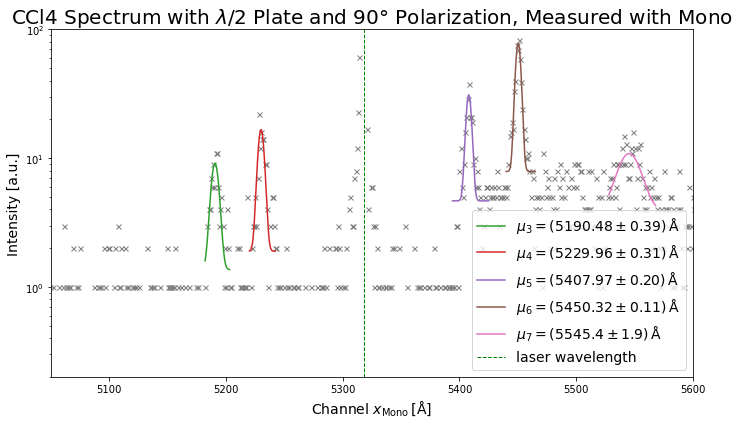

In [63]:
I_lamb90 = np.zeros((5,4))
title = r'CCl4 Spectrum with $\lambda/2$ Plate and $90\degree$ Polarization, Measured with Mono'
spectrum = 'CCl4_lamb_90deg'
N = 6
func1=0
func2=gauss
y_counts = df_CCl4['Counts']
a = [[187, 226], [281, 305], [315, 345], [495, 525], [535, 565], [634, 662]]
p1s = [[7, 5105, 10, 7, 5110,10, 0], [10, 5541, 10, 10, 5552, 10, 0]]
p0s = [[7, 5105, 10, 0], [40, 5190, 10, 0], [70, 5230, 10, 0],
       [150, 5410, 10, 0], [175, 5450, 10, 0], [10, 5545, 10, 5]]
xaxis = [np.linspace(5095, 5122, 1001), np.linspace(5182, 5203, 1001), np.linspace(5220, 5242, 1001),
         np.linspace(5394, 5425, 1001), np.linspace(5440,5465,1001), np.linspace(5528, 5568, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df_CCl4['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
I_lamb90[:,0], I_lamb90[:,2] = coefficients[1:,0], coefficients[1:,1]
I_lamb90[:,1], I_lamb90[:,3] = np.sqrt(covariance[1:,0,0]), np.sqrt(covariance[1:,1,1])
draw_spectrum(num_fit=N, x=df_CCl4['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[0.2, 100], xlims=[5050,5600],avline=0,loc='lower right')

In [64]:
save_params(spectrum, coefficients, covariance)

lambda = 519.42 \pm 0.064
d_nu = -459 \pm 6.5
lambda = 523.37 \pm 0.059
d_nu = -314 \pm 6.4
lambda = 541.16 \pm 0.055
d_nu = 314 \pm 6.3
lambda = 545.39 \pm 0.053
d_nu = 457 \pm 6.3
lambda = 554.89 \pm 0.19
d_nu = 771 \pm 8.8
Successfully saved!


**Analysis Depolarization**

In [77]:
def u_corr(x, ux):
    dy = np.zeros(3)

    dy[0] = x
    dy[1] = 1
    dy[2] = lin_par[0]

    cov = np.zeros((3,3))
    cov[0:2, 0:2] = lin_cov
    cov[2, 2] = ux**2

    u_corr_facs = np.sqrt(dy @ cov @ dy)
    return u_corr_facs

In [78]:
def depol(I0, I90):
    x = (I0[:,2]+I90[:,2]) / 2
    ux = 1/2 * np.sqrt(I0[:,3]**2 + I90[:,3]**2)
    
    corr_facs = np.polyval(lin_par, x)
    
    u_corr_facs = np.array([])

    dvs = np.array([])
    u_dvs = np.array([])
    
    for w, uw in zip(x, ux):
        u_corr_facs = np.append(u_corr_facs, u_corr(w, uw))
        
        w = wave(w, uw)           
        nu = np.array(d_v(*w)) * 1e7
        dvs = np.append(dvs, nu[0])
        u_dvs = np.append(u_dvs, nu[1])
   
    rho = (corr_facs * I_90[:,0]) / I_0[:,0]
    u_rho = rho * np.sqrt((u_corr_facs/corr_facs)**2 + (I90[:,1]/I90[:,0])**2 + (I0[:,1]/I0[:,0])**2)
    
    
    return rho, u_rho, dvs, u_dvs

rho, urho, w, uw = depol(I_0, I_90)
#print(rho, urho, w, uw)
rho, urho, w, uw = depol(I_lamb0, I_lamb90)
#print(rho, urho, w, uw)



# def depol(I0, I90):
#     wavelength = (I0[:,2]+I90[:,2]) / 2
#     u_wavelength = 1/2 * np.sqrt(I0[:,3]**2 + I90[:,3]**2)

#     corr_facs = np.polyval(lin_par, wavelength)
#     u_corr_facs = np.sqrt((lin_par[0]*u_wavelength)**2
#                           + (np.sqrt(lin_cov[1,1]))**2
#                           + (wavelength*np.sqrt(lin_cov[0,0]))**2
#                           + (2*wavelength*lin_cov[0,1]))
#     print(corr_facs)
#     rho = (corr_facs * I_90[:,0]) / I_0[:,0]
#     u_rho = rho * np.sqrt((u_corr_facs/corr_facs)**2 + (I90[:,1]/I90[:,0])**2 + (I0[:,1]/I0[:,0])**2)
#     return rho, u_rho, wavelength
    
# rho, urho, w = depol(I_0, I_90)
# print(rho, urho, w)
# rho, urho, w = depol(I_lamb0, I_lamb90)
# print(rho, urho, w)

In [79]:
def save_pols():
    
    rho, u_rho, dvs, u_dvs = depol(I_0, I_90)
    rho_lamb, u_rho_lamb, dvs_lamb, u_dvs_lamb = depol(I_lamb0, I_lamb90)
    
    dvs_mean = 0.5*(dvs + dvs_lamb)
    u_dvs_mean = 0.5*np.sqrt(u_dvs**2 + u_dvs_lamb**2)

    output_data = pd.DataFrame({'dnu': dvs_mean,
                                'u(dnu)': u_dvs_mean,
                                'rho' : rho,
                                'u_rho' : u_rho,
                                'rho_lamb' : rho_lamb,
                                'u_rho_lamb' : u_rho_lamb,
                               })

    output_data.to_csv('Mono_depol_degrees.csv', index=False, sep=',')
    print('Successfully saved!')
    
    return None
    
    
save_pols()

Successfully saved!


In [80]:
def save_Is():
    
    rho, u_rho, dvs, u_dvs = depol(I_0, I_90)
    
    output_data = pd.DataFrame({'dnu': dvs,
                                'I_0': I_0[:,0],
                                'u_I_0': I_0[:,1],
                                'I_90' : I_90[:,0],
                                'u_I_90' : I_90[:,1],
                                'I_lamb0': I_lamb0[:,0],
                                'u_I_lamb0': I_lamb0[:,1],
                                'I_lamb90' : I_lamb90[:,0],
                                'u_I_lamb90' : I_lamb90[:,1],
                               })

    output_data.to_csv('Mono_Intensities.csv', index=False, sep=',')
    print('Successfully saved!')
    
    return None
    
    
save_Is()

Successfully saved!


**CH2Cl2 Spectrum**

In [66]:
file = 'Mono/CH2Cl2_spectrum_2.dig'
df = pd.read_csv(file, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')
print(df['Channel'])

0       4901.0
1       4902.0
2       4903.0
3       4904.0
4       4905.0
         ...  
1219    6120.0
1220    6121.0
1221    6122.0
1222    6123.0
1223    6124.0
Name: Channel, Length: 1224, dtype: float64


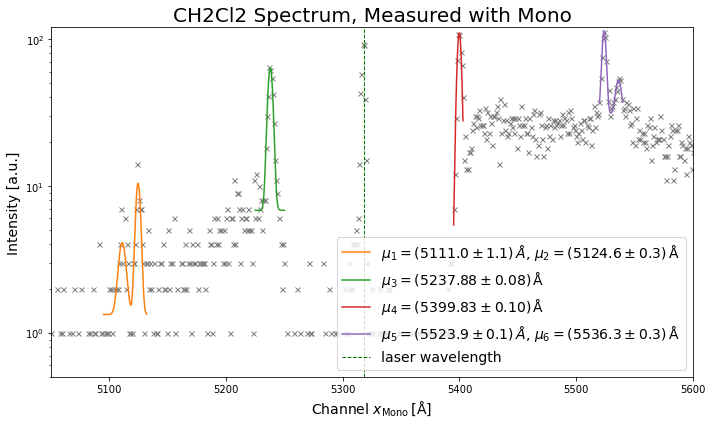

In [67]:
title = r'CH2Cl2 Spectrum, Measured with Mono'
spectrum = 'CH2Cl2'
N = 4
func1=doppel_gauss
func2=doppel_gauss
y_counts = df['Counts']
a = [[195, 232], [325, 346], [490, 502], [615, 641], [535, 565], [634, 662]]
p1s = [[10, 5110, 10, 11, 5130,10, 0], [100, 5540, 10, 100, 5550, 10, 0]]
p0s = [[7, 5105, 10, 0], [100, 5230, 10, 0], [100, 5400, 10, 0],
       [150, 5410, 10, 0], [175, 5450, 10, 0], [10, 5545, 10, 5]]
xaxis = [np.linspace(5095, 5132, 1001), np.linspace(5225, 5250, 1001), np.linspace(5395, 5403, 1001),
         np.linspace(5520, 5540, 1001), np.linspace(5440,5465,1001), np.linspace(5528, 5568, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
draw_spectrum(num_fit=N, x=df['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[0.5,120], xlims=[5050,5600],avline=0)

In [68]:
save_params(spectrum, coefficients, covariance)

lambda = 511.48 \pm 0.12
d_nu = -758 \pm 7.6
lambda = 512.84 \pm 0.057
d_nu = -707 \pm 6.4
lambda = 524.16 \pm 0.051
d_nu = -285 \pm 6.3
lambda = 540.34 \pm 0.052
d_nu = 286 \pm 6.3
lambda = 552.74 \pm 0.053
d_nu = 701 \pm 6.3
lambda = 553.98 \pm 0.062
d_nu = 742 \pm 6.4
Successfully saved!


**CHCl3 Spectrum**

In [75]:
file = 'Mono/CHCl3_spectrum_2.dig'
df = pd.read_csv(file, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

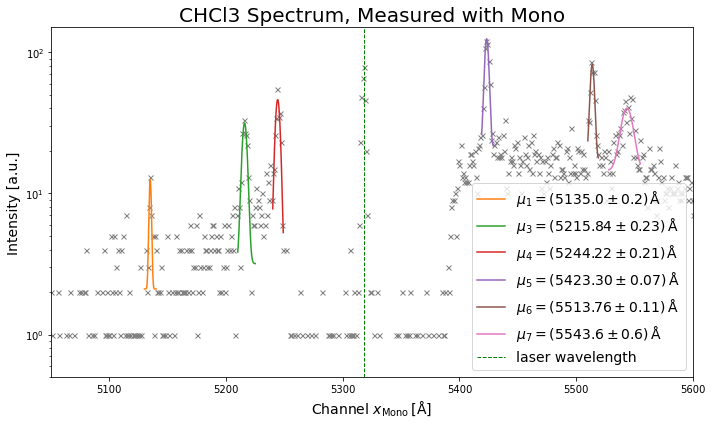

In [76]:
title = r'CHCl3 Spectrum, Measured with Mono'
spectrum = 'CHCl3'
N = 6
func1=gauss
func2=gauss
y_counts = df['Counts']
a = [[227, 241], [310, 320], [339, 351], [515, 530], [600, 620], [634, 660]]
p1s = [[10, 5135, 10, 11, 5130,10, 0], [100, 5540, 10, 100, 5550, 10, 0]]
p0s = [[10, 5140, 10, 0], [100, 5230, 10, 0], [100, 5243, 10, 0],
       [200, 5421, 10, 0], [175, 5510, 10, 0], [10, 5545, 10, 5]]
xaxis = [np.linspace(5130, 5140, 1001), np.linspace(5210, 5225, 1001), np.linspace(5240, 5249, 1001),
         np.linspace(5419, 5429, 1001), np.linspace(5510,5519,1001), np.linspace(5528, 5555, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
draw_spectrum(num_fit=N, x=df['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[0.5,150], xlims=[5050,5600],avline=0)

In [71]:
save_params(spectrum, coefficients, covariance)

lambda = 513.87 \pm 0.053
d_nu = -667 \pm 6.4
lambda = 521.95 \pm 0.056
d_nu = -366 \pm 6.4
lambda = 524.79 \pm 0.055
d_nu = -262 \pm 6.4
lambda = 542.69 \pm 0.052
d_nu = 366 \pm 6.3
lambda = 551.73 \pm 0.053
d_nu = 668 \pm 6.3
lambda = 554.71 \pm 0.082
d_nu = 765 \pm 6.6
Successfully saved!


**CS2 Spectrum**

In [72]:
file = 'Mono/CS2_spectrum_2.dig'
df = pd.read_csv(file, skiprows=1, skipfooter=0, sep='\t', names=['Channel', 'Counts'], decimal=',')

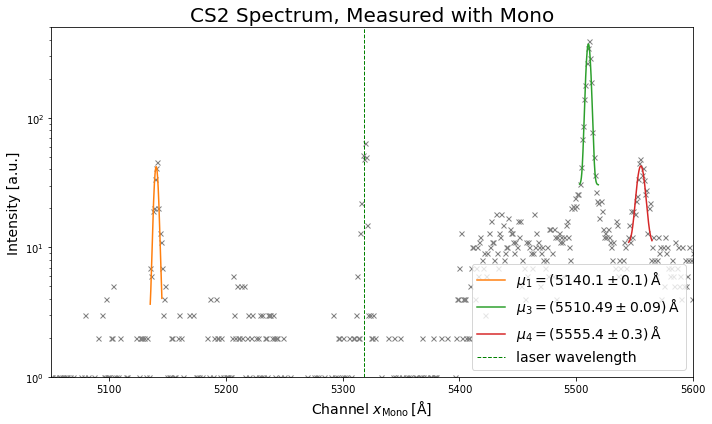

In [73]:
title = r'CS2 Spectrum, Measured with Mono'
spectrum = 'CS2'
N = 3
func1=gauss
func2=gauss
y_counts = df['Counts']
a = [[227, 249], [600, 620], [640, 670], [515, 530], [600, 620], [634, 660]]
p1s = [[10, 5135, 10, 11, 5130,10, 0], [100, 5540, 10, 100, 5550, 10, 0]]
p0s = [[10, 5140, 10, 0], [100, 5510, 10, 0], [100, 5570, 10, 0],
       [200, 5421, 10, 0], [175, 5510, 10, 0], [10, 5545, 10, 5]]
xaxis = [np.linspace(5135, 5145, 1001), np.linspace(5503, 5519, 1001), np.linspace(5545, 5565, 1001),
         np.linspace(5419, 5429, 1001), np.linspace(5510,5519,1001), np.linspace(5528, 5555, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
coefficients, covariance = fit_func(N=N, x=df['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
draw_spectrum(num_fit=N, x=df['Channel'], y=y_counts, a=a, xaxis=xaxis,
              xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
              func1=func1, func2=func2,spectrum=spectrum,log=True,ylims=[1,500], xlims=[5050,5600],avline=0)

In [74]:
save_params(spectrum, coefficients, covariance)

lambda = 514.39 \pm 0.052
d_nu = -648 \pm 6.4
lambda = 551.4 \pm 0.053
d_nu = 657 \pm 6.3
lambda = 555.89 \pm 0.058
d_nu = 804 \pm 6.3
Successfully saved!
